In [13]:
import numpy as np
import pandas as pd
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statistics
import math
    
def read_data(start_date, end_date):
    df=pd.read_csv('6_Portfolios_2x3.CSV')
    df=df.dropna()
    df['date'] = df['date'].astype(int)
    ps=df[(df.date >= start_date) & (df.date <= end_date)]
    ps=ps.reset_index(drop=True)
    ps.iloc[:,1:]=ps.iloc[:,1:].astype(float)
    ps['LongP']= (ps['SMALL LoBM']+ ps['ME1 BM2']+ ps['SMALL HiBM'])/3
    ps['ShortP']=-(ps['BIG LoBM']+ ps['ME2 BM2']+ ps['BIG HiBM'])/3
    ps['p_return']=ps['LongP']+ps['ShortP']
    
    data=pd.read_csv('F-F_Research_Data_Factors.CSV')
    data=data.dropna()
    data['date'] = data['date'].astype(int)
    
    df_de=pd.read_csv('Portfolios_Formed_on_ME.CSV')
    df_de=df_de.dropna()
    df_de['date'] = df_de['date'].astype(int)
    ps3=df_de[(df_de.date >= start_date) & (df_de.date <= end_date)]
    ps3=ps3.reset_index(drop=True)
    ps3.iloc[:,1:]=ps3.iloc[:,1:].astype(float)
    ps3['p_return']=ps3['Lo 10']-ps3['Hi 10']
    
    bab=pd.read_csv('Betting Against Beta Equity Factors Monthly.csv')
    bab['DATE']=pd.to_datetime(bab.DATE).dt.strftime('%Y%m')
    bab['DATE']=bab['DATE'].astype(int)
    bab=bab.rename(columns={"DATE": "date"})
    bab1=bab[(bab.date >= start_date) & (bab.date <= end_date)]
    bab1=bab1.reset_index(drop=True)
    bab1['USA']=bab1['USA'].str.strip('%').astype(float)
    
    return df, ps, data, df_de, ps3, bab, bab1

In [80]:
def Exhibit_1(start_date: int, end_date: int, output_csv_name: str, print_output:bool = True):
    
    df, ps, data, df_de, ps3, bab, bab1 = read_data(start_date, end_date)

    #Exhibit 1 item 1 (mean)
    E1_1=((1+ps['p_return'].mean()/100)**12-1)*100
    #Exhibit 1  item 2 (sd)
    E1_2=ps['p_return'].std()*(12)**0.5
    #Exhibit 1 item 3 (t-statistic)
    E1_3=ps['p_return'].mean()/(ps['p_return'].std()/(480**0.5))
    #Exhibit 1 item 4 (Sharp ratio)
    E1_4=E1_1/E1_2
    #Merging data to get RF

    df2=data[(data.date >= start_date) & (data.date <= end_date)]
    df2=df2.reset_index(drop=True)
    df2.iloc[:,1:]=df2.iloc[:,1:].astype(float)
    newps=pd.merge(ps,df2,how='inner',on='date')
    newps=newps.rename(columns={"Mkt-RF": "MktRF"})
    #Regression
    mod = smf.ols(formula=' SMB ~ MktRF', data=newps)
    res = mod.fit(cov_type='HC3')
    #print(res.summary())

    # Annual Alpha Vs. CAPM 1
    intercept1 = res.params[0]  # The intercept of the regression model
    monthly_alpha1 = intercept1  # The expected excess return per month
    alpha1 = ((1 + monthly_alpha1 / 100) ** 12 - 1) * 100
    # alpha1=((1-0.0234/100)**12-1)*100

    #ALpha t-stats & IR Vs. CAPM 1
    tstat1 = res.tvalues['Intercept']
    resd=statistics.stdev(res.resid)
    IR1=alpha1/(resd*(12**0.5))

    # Exhibit 1 Row 1
    E1_R1=[round(E1_1,1), round(E1_2,1), round(E1_3,2), round(E1_4,2), round(alpha1,1), round(tstat1,2), round(IR1,2),f'{str(start_date)[4:]}/30/{math.floor(start_date/100)}',f'{str(end_date)[4:]}/30/{math.floor(end_date/100)}']

    # Exhibits 1  Row 2 (decile 1-10)


    #Exhibit 1  Row 2 item 1 (mean)
    E1_r2_1=ps3['p_return'].mean()*12

    #Exhibit 1 Row2 item 2 (sd)
    E1_r2_2=ps3['p_return'].std()*(12)**0.5

    #Exhibit 1 Row2 item 3 (t-statistic)
    E1_r2_3=ps3['p_return'].mean()/(ps3['p_return'].std()/(480**0.5))

    #Exhibit 1 Row2 item 4 (Sharp ratio)
    E1_r2_4=E1_r2_1/E1_r2_2

    #Regression
    newps3=pd.merge(ps3,df2,how='inner',on='date')
    newps3=newps3.rename(columns={"Mkt-RF": "MktRF"})
    mod3 = smf.ols(formula=' p_return ~ MktRF', data=newps3)
    res3 = mod3.fit()
    #print(res3.summary())

    # Annual Alpha Vs. CAPM 1 Exhibit 1 Row 2
    intercept2 = res3.params[0]  # The intercept of the regression model for Row 2
    monthly_alpha2 = intercept2  # The expected excess return per month
    r2_alpha1 = ((1 + monthly_alpha2 / 100) ** 12 - 1) * 100
    # r2_alpha1=((1+0.2042/100)**12-1)*100

    #ALpha t-stats & IR Vs. CAPM 1 Exhibit 1 Row 2
    r2_tstat1 = res3.tvalues['Intercept']
    resd3=statistics.stdev(res3.resid)
    r2_IR1=r2_alpha1/(resd3*(12**0.5))

    # Exhibit 1 Row 2
    E1_R2=[round(E1_r2_1,1), round(E1_r2_2,1), round(E1_r2_3,2), round(E1_r2_4,2), round(r2_alpha1,1), round(r2_tstat1,2), round(r2_IR1,2),f'{str(start_date)[4:]}/30/{math.floor(start_date/100)}',f'{str(end_date)[4:]}/30/{math.floor(end_date/100)}']

    # Exhibit 1
    d1 = {'SMB':E1_R1 , 'Decile 1-10':E1_R2}
    Exhibit1 = pd.DataFrame(data=d1,index=['Annual Return','Annual Vol','Raw t-stat','Sharp Ratio','Annual Alpha vs. CAPM','Alpha t-stat vs. CAPM','IR vs. CAPM','Start Date','End Date'])
    Exhibit1=Exhibit1.transpose()
    Exhibit1.to_csv(f'{output_csv_name}.csv')
    if print_output:
        print(Exhibit1)
    return E1_R1

In [81]:
# Making Exhibit 1
Exhibit_1(193601,197512, "Exhibit1", print_output=True)

            Annual Return Annual Vol Raw t-stat Sharp Ratio  \
SMB                   1.9        9.8       1.21        0.19   
Decile 1-10           7.1       25.2       1.78        0.28   

            Annual Alpha vs. CAPM Alpha t-stat vs. CAPM IR vs. CAPM  \
SMB                          -0.3                 -0.24       -0.04   
Decile 1-10                   2.5                  0.66        0.11   

             Start Date    End Date  
SMB          01/30/1936  12/30/1975  
Decile 1-10  01/30/1936  12/30/1975  


[1.9, 9.8, 1.21, 0.19, -0.3, -0.24, -0.04, '01/30/1936', '12/30/1975']

In [82]:
# Making Exhibit 2
Exhibit_1(192607,201712, "Exhibit2", print_output=True)

            Annual Return Annual Vol Raw t-stat Sharp Ratio  \
SMB                   2.3       10.4       1.36        0.22   
Decile 1-10           6.0       25.5       1.49        0.24   

            Annual Alpha vs. CAPM Alpha t-stat vs. CAPM IR vs. CAPM  \
SMB                           0.7                  0.73        0.07   
Decile 1-10                   2.2                  0.85        0.09   

             Start Date    End Date  
SMB          07/30/1926  12/30/2017  
Decile 1-10  07/30/1926  12/30/2017  


[2.3, 10.4, 1.36, 0.22, 0.7, 0.73, 0.07, '07/30/1926', '12/30/2017']

In [83]:
# Exhibit 2 with data up to 2024
Exhibit_1(162607,202406, "Exhibit 2 updated", print_output=True)

            Annual Return Annual Vol Raw t-stat Sharp Ratio  \
SMB                   1.9       10.1       1.19        0.19   
Decile 1-10           5.0       25.1       1.25         0.2   

            Annual Alpha vs. CAPM Alpha t-stat vs. CAPM IR vs. CAPM  \
SMB                           0.1                  0.09        0.01   
Decile 1-10                   1.2                  0.49        0.05   

             Start Date    End Date  
SMB          07/30/1626  06/30/2024  
Decile 1-10  07/30/1626  06/30/2024  


[1.9, 10.1, 1.19, 0.19, 0.1, 0.09, 0.01, '07/30/1626', '06/30/2024']

In [93]:
##Making Exhibit 3
#BAB
def Exhibit_3(bab_start_date, bab_end_date, hml_start_date, hml_end_date,
              mom_start_date, mom_end_date, rmw_start_date, rmw_end_date, smb_start_date,
              smb_end_date, output_name):
    
    df, ps, data, df_de, ps3, bab, bab1 = read_data(hml_start_date, hml_end_date)
    E2_R1 = Exhibit_1(smb_start_date, smb_end_date, "Exhibit2", print_output=False)
    
    #Exhibit 3 Row 1 item 1 (mean)
    E3_r1_1=bab1['USA'].mean()*12
    #Exhibit 3 Row 1 item 2 (sd)
    E3_r1_2=bab1['USA'].std()*(12)**0.5
    #Exhibit 3 Row 1 item 3 (t-statistic)
    E3_r1_3=bab1['USA'].mean()/(bab1['USA'].std()/(len(bab1['USA'])**0.5))
    #Exhibit 3 Row 1 item 4 (Sharp ratio)
    E3_r1_4=E3_r1_1/E3_r1_2


    #Merging data to get RF
    df_E3_r1=data[(data.date >= bab_start_date) & (data.date <= bab_end_date)]
    df_E3_r1=df_E3_r1.reset_index(drop=True)
    df_E3_r1.iloc[:,1:]=df_E3_r1.iloc[:,1:].astype(float)
    newbab1=pd.merge(bab1,df_E3_r1,how='inner',on='date')
    newbab1=newbab1.rename(columns={"Mkt-RF": "MktRF"})

    #Regression
    mod_E3_r1 = smf.ols(formula=' USA ~ MktRF', data=newbab1)
    res_E3_r1 = mod_E3_r1.fit()

    # Annual Alpha Vs. CAPM 
    alpha_E3_r1=res_E3_r1.params[0]*12

    #ALpha t-stats & IR Vs. CAPM 
    tstat_E3_r1=res_E3_r1.t_test([1,0]).tvalue[0][0]
    resd_E3_r1=statistics.stdev(res_E3_r1.resid)
    IR_E3_r1=alpha_E3_r1/(resd_E3_r1*(12**0.5))

    # Exhibit 3 Row 1
    E3_R1=[round(E3_r1_1,1), round(E3_r1_2,1), round(E3_r1_3,2), round(E3_r1_4,2),
           round(alpha_E3_r1,1), round(tstat_E3_r1,2), round(IR_E3_r1,2),
           f'{str(bab_start_date)[4:]}/31/{str(bab_start_date)[:4]}',
           f'{str(bab_end_date)[4:]}/31/{str(bab_end_date)[:4]}']

    # Exhibits 3  Row 2 (HML)
    HML=data[(data.date >= hml_start_date) & (data.date <= hml_end_date)]
    HML=HML.reset_index(drop=True)
    HML['HML']=HML['HML'].astype(float)

    #Exhibit 3 Row 2 item 1 (mean)
    E3_r2_1=HML['HML'].mean()*12
    #Exhibit 3 Row 2 item 2 (sd)
    E3_r2_2=HML['HML'].std()*(12)**0.5
    #Exhibit 3 Row 1 item 3 (t-statistic)
    E3_r2_3=HML['HML'].mean()/(HML['HML'].std()/(len(HML)**0.5))
    #Exhibit 3 Row 2 item 4 (Sharp ratio)
    E3_r2_4=E3_r2_1/E3_r2_2

    #Regression
    HML=HML.rename(columns={"Mkt-RF": "MktRF"})
    mod_E3_r2 = smf.ols(formula=' HML ~ MktRF', data=HML)
    res_E3_r2 = mod_E3_r2.fit()
    #print(res_E3_r2.summary())

    # Annual Alpha Vs. CAPM 
    alpha_E3_r2=res_E3_r2.params[0]*12

    #ALpha t-stats & IR Vs. CAPM 
    tstat_E3_r2=res_E3_r2.t_test([1,0]).tvalue[0][0]
    resd_E3_r2=statistics.stdev(res_E3_r2.resid)
    IR_E3_r2=alpha_E3_r2/(resd_E3_r2*(12**0.5))

    # Exhibit 3 Row 2
    E3_R2=[round(E3_r2_1,1), round(E3_r2_2,1), round(E3_r2_3,2), round(E3_r2_4,2),
           round(alpha_E3_r2,1), round(tstat_E3_r2,2), round(IR_E3_r2,2),
           f'{str(hml_start_date)[4:]}/31/{str(hml_start_date)[:4]}',
           f'{str(hml_end_date)[4:]}/31/{str(hml_end_date)[:4]}']
    # Exhibits 3  Row 3 (UMD)
    UMD=pd.read_csv('F-F_Momentum_Factor.CSV')
    UMD=UMD.dropna()
    UMD['date']=UMD['date'].astype(int)
    UMD=UMD[(UMD.date >= mom_start_date) & (UMD.date <= mom_end_date)]
    UMD=UMD.rename(columns={"Mom   ": "Mom"})
    UMD['Mom']=UMD['Mom'].astype(float)


    #Exhibit 3 Row 3 item 1 (mean)
    E3_r3_1=UMD['Mom'].mean()*12
    #Exhibit 3 Row 3 item 2 (sd)
    E3_r3_2=UMD['Mom'].std()*(12)**0.5
    #Exhibit 3 Row 3 item 3 (t-statistic)
    E3_r3_3=UMD['Mom'].mean()/(UMD['Mom'].std()/(len(UMD)**0.5))
    #Exhibit 3 Row 1 item 4 (Sharp ratio)
    E3_r3_4=E3_r3_1/E3_r3_2

    #Merging data to get RF
    df_E3_r3=data[(data.date >= mom_start_date) & (data.date <= mom_end_date)]
    df_E3_r3=df_E3_r3.reset_index(drop=True)
    df_E3_r3.iloc[:,1:]=df_E3_r3.iloc[:,1:].astype(float)
    newUMD=pd.merge(UMD,df_E3_r3,how='inner',on='date')
    newUMD=newUMD.rename(columns={"Mkt-RF": "MktRF"})

    #Regression
    mod_E3_r3 = smf.ols(formula=' Mom ~ MktRF', data=newUMD)
    res_E3_r3 = mod_E3_r3.fit()
    #print(res_E3_r3.summary())

    # Annual Alpha Vs. CAPM 
    alpha_E3_r3=res_E3_r3.params[0]*12

    #ALpha t-stats & IR Vs. CAPM 
    tstat_E3_r3=res_E3_r3.t_test([1,0]).tvalue[0][0]
    resd_E3_r3=statistics.stdev(res_E3_r3.resid)
    IR_E3_r3=alpha_E3_r3/(resd_E3_r3*(12**0.5))

    # Exhibit 3 Row 3
    E3_R3=[round(E3_r3_1,1), round(E3_r3_2,1), round(E3_r3_3,2), round(E3_r3_4,2),
           round(alpha_E3_r3,1), round(tstat_E3_r3,2), round(IR_E3_r3,2),
           f'{str(mom_start_date)[4:]}/31/{str(mom_start_date)[:4]}',
           f'{str(mom_end_date)[4:]}/31/{str(mom_end_date)[:4]}']

    # Exhibits 3  Row 4 (RMW)
    df_RMW=pd.read_csv('F-F_Research_Data_5_Factors_2x3.CSV')
    df_RMW['date']=df_RMW['date'].astype(int)
    df_RMW=df_RMW[(df_RMW.date >= rmw_start_date) & (df_RMW.date <= rmw_end_date)]
    df_RMW=df_RMW.reset_index(drop=True)
    df_RMW.iloc[:,1:]=df_RMW.iloc[:,1:].astype(float)

    #Exhibit 3 Row 4 item 1 (mean)
    E3_r4_1=df_RMW['RMW'].mean()*12
    #Exhibit 3 Row 4 item 2 (sd)
    E3_r4_2=df_RMW['RMW'].std()*(12)**0.5
    #Exhibit 3 Row 4 item 3 (t-statistic)
    E3_r4_3=df_RMW['RMW'].mean()/(df_RMW['RMW'].std()/(len(df_RMW)**0.5))
    #Exhibit 3 Row 4 item 4 (Sharp ratio)
    E3_r4_4=E3_r4_1/E3_r4_2

    #Regression
    df_RMW=df_RMW.rename(columns={"Mkt-RF": "MktRF"})
    mod_E3_r4 = smf.ols(formula='RMW ~ MktRF', data=df_RMW)
    res_E3_r4 = mod_E3_r4.fit()
    #print(res_E3_r4.summary())

    # Annual Alpha Vs. CAPM 
    alpha_E3_r4=res_E3_r4.params[0]*12

    #ALpha t-stats & IR Vs. CAPM 
    tstat_E3_r4=res_E3_r4.t_test([1,0]).tvalue[0][0]
    resd_E3_r4=statistics.stdev(res_E3_r4.resid)
    IR_E3_r4=alpha_E3_r4/(resd_E3_r4*(12**0.5))

    # Exhibit 3 Row 4
    E3_R4=[round(E3_r4_1,1), round(E3_r4_2,1), round(E3_r4_3,2), round(E3_r4_4,2),
           round(alpha_E3_r4,1), round(tstat_E3_r4,2), round(IR_E3_r4,2),
           f'{str(rmw_start_date)[4:]}/31/{str(rmw_start_date)[:4]}',
           f'{str(rmw_end_date)[4:]}/31/{str(rmw_end_date)[:4]}']

    # Exhibits 3  Row 5 (SMB)
    E3_R5=E2_R1

    # Exhibit 3
    d3 = {'BAB':E3_R1 , 'HML':E3_R2, 'MOM': E3_R3, 'RMW':E3_R4, 'SMB':E3_R5}
    Exhibit3 = pd.DataFrame(data=d3,index=['Annual Return','Annual Vol','Raw t-stat','Sharp Ratio','Annual Alpha vs. CAPM','Alpha t-stat vs. CAPM','IR vs. CAPM','Start Date','End Date'])
    Exhibit3=Exhibit3.transpose()
    Exhibit3.to_csv(f'{output_name}.csv')
    print(Exhibit3)


In [94]:
Exhibit_3(193012,201712,192607,201712,192701,201712,196307,201712,192607,201712, "Exhibit3")

    Annual Return Annual Vol Raw t-stat Sharp Ratio Annual Alpha vs. CAPM  \
BAB           8.4       11.3       6.95        0.74                   9.1   
HML           4.6       12.2       3.61        0.38                   3.3   
MOM           7.9       16.4       4.62        0.48                  10.3   
RMW           3.1        7.6       3.04        0.41                   3.9   
SMB           2.3       10.4       1.36        0.22                   0.7   

    Alpha t-stat vs. CAPM IR vs. CAPM  Start Date    End Date  
BAB                  7.55        0.82  12/31/1930  12/31/2017  
HML                  2.66        0.28  07/31/1926  12/31/2017  
MOM                  6.33        0.67  01/31/1927  12/31/2017  
RMW                   3.8        0.52  07/31/1963  12/31/2017  
SMB                  0.73        0.07  07/30/1926  12/30/2017  


In [95]:
Exhibit_3(193012,202406,192607,202406,192701,202406,196307,202406,192607,202406, "Exhibit3 updated")

    Annual Return Annual Vol Raw t-stat Sharp Ratio Annual Alpha vs. CAPM  \
BAB           8.0       11.2        6.9        0.71                   8.7   
HML           4.1       12.4       3.27        0.33                   2.8   
MOM           7.5       16.3       4.58        0.46                  10.0   
RMW           3.5        7.7       3.52        0.45                   4.1   
SMB           1.9       10.1       1.19        0.19                   0.1   

    Alpha t-stat vs. CAPM IR vs. CAPM  Start Date    End Date  
BAB                   7.5        0.78  12/31/1930  06/31/2024  
HML                  2.32        0.24  07/31/1926  06/31/2024  
MOM                  6.42        0.66  01/31/1927  06/31/2024  
RMW                   4.2        0.54  07/31/1963  06/31/2024  
SMB                  0.09        0.01  07/30/1926  06/30/2024  


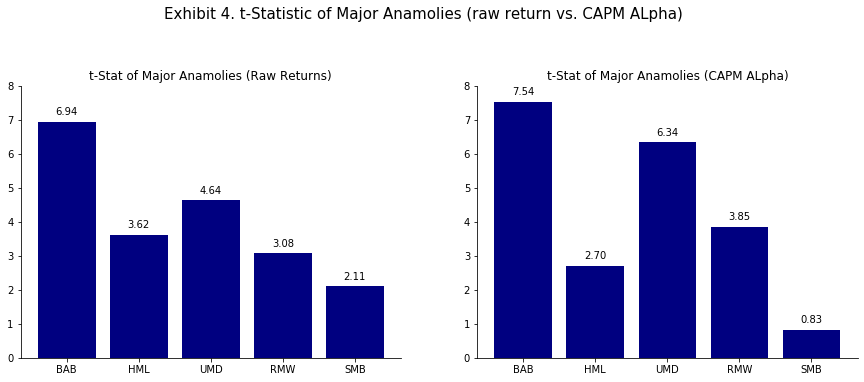

In [6]:
# Exhibit 4
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(15, 5))
anamolies = ['BAB', 'HML', 'UMD', 'RMW', 'SMB']
ax[0].bar(anamolies,Exhibit3['Raw t-stat'],color="#000080")
ax[0].set_ylim([0, 8])
ax[0].set_title('t-Stat of Major Anamolies (Raw Returns)')

ax[1].bar(anamolies,Exhibit3['Alpha t-stat vs. CAPM'],color="#000080")
ax[1].set_ylim([0, 8])
ax[1].set_title('t-Stat of Major Anamolies (CAPM ALpha)')

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax[0])
add_value_labels(ax[1])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
fig.suptitle('Exhibit 4. t-Statistic of Major Anamolies (raw return vs. CAPM ALpha) ', fontsize=15,y=1.1)
fig.savefig("Exhibit 4.png",bbox_inches='tight',pad_inches=0.5)

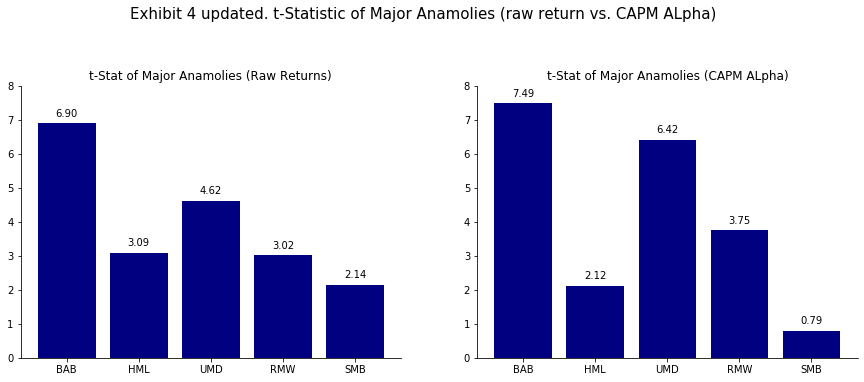

In [7]:
# Exhibit 4 updated 

fig, ax = plt.subplots(1, 2,figsize=(15, 5))
anamolies = ['BAB', 'HML', 'UMD', 'RMW', 'SMB']
ax[0].bar(anamolies,Exhibit3u['Raw t-stat'],color="#000080")
ax[0].set_ylim([0, 8])
ax[0].set_title('t-Stat of Major Anamolies (Raw Returns)')

ax[1].bar(anamolies,Exhibit3u['Alpha t-stat vs. CAPM'],color="#000080")
ax[1].set_ylim([0, 8])
ax[1].set_title('t-Stat of Major Anamolies (CAPM ALpha)')

add_value_labels(ax[0])
add_value_labels(ax[1])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
fig.suptitle('Exhibit 4 updated. t-Statistic of Major Anamolies (raw return vs. CAPM ALpha) ', fontsize=15,y=1.1)
fig.savefig("Exhibit 4 updated.png",bbox_inches='tight',pad_inches=0.5)

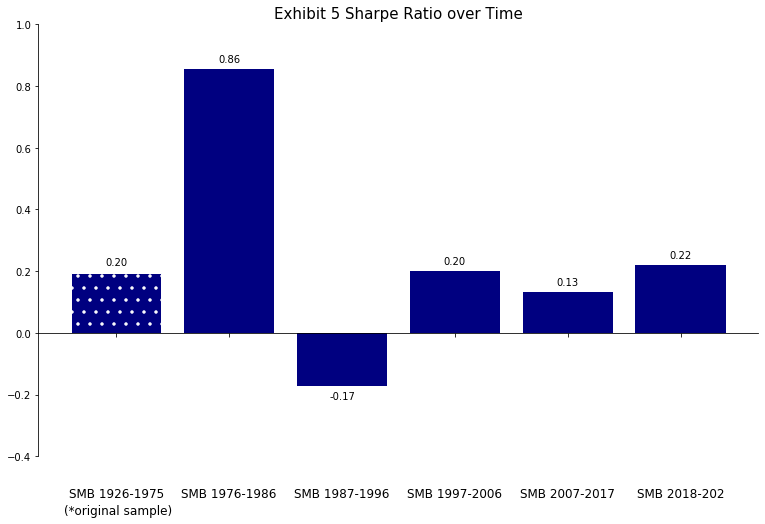

In [57]:
#Exhibit 5 (updated)
i=0
E5=[E1_4]
decades=[197601,198612,198701,199612,199701,200612,200701,201712,201801,202012]
seq=[0,2,4,6,8]
for i in seq:
    time_0 = decades[i]
    time_t = decades[i+1]
    df_E5=data[(data.date >= time_0) & (data.date <= time_t)]
    df_E5=df_E5.reset_index(drop=True)
    df_E5.iloc[:,1:]=df_E5.astype(float)
    #mean
    E5_1=df_E5['SMB'].mean()*12
    #sd
    E5_2=df_E5['SMB'].std()*(12)**0.5
    #Sharp ratio
    E5.append(E5_1/E5_2)
E5
E5_xtitle=['SMB 1926-1975', 'SMB 1976-1986','SMB 1987-1996','SMB 1997-2006','SMB 2007-2017','SMB 2018-202']
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
bar1=ax.bar(E5_xtitle,E5,color="#000080")
ax.set_ylim([-0.4, 1])
ax.set_title('Exhibit 5 Sharpe Ratio over Time',fontsize=15)
add_value_labels(ax)


# Get the axes object
ax = plt.gca()
# remove the existing ticklabels
ax.set_xticklabels([])
# remove the extra tick on the negative bar
ax.set_xticks([idx for (idx, x) in enumerate(E5) if x > 0])
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# placing each of the x-axis labels individually
label_offset = 0.5
for language, (x_position, y_position) in zip(E5_xtitle, enumerate(E5)): 
    ax.text(x_position, label_y, language, ha="center", va="top",fontsize=12)
bar1[0].set_hatch('.')
bar1[0].set_edgecolor('w')
ax.text(0.11, -0.11, "(*original sample)", ha="center", va="top", transform=ax.transAxes,fontsize=12)
plt.show()
fig.savefig("Exhibit 5 updated.png",bbox_inches='tight',pad_inches=0.5)

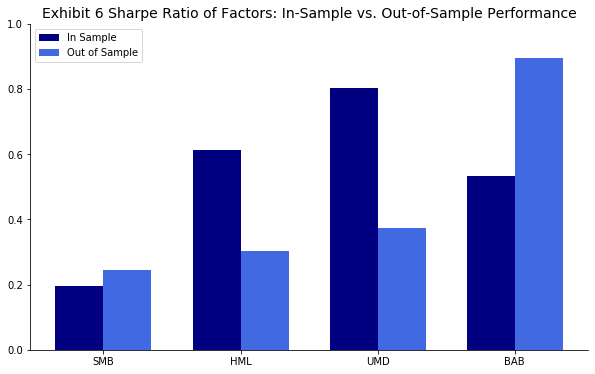

In [93]:
# Exhibit 6
#SMB
#SMB in sample Sharp ratio already calculated
smb_in=E1_4

SMB_out=data[(data.date >= 197601) & (data.date <= 201712)]
SMB_out=SMB_out.reset_index(drop=True)
SMB_out.iloc[:,1:]=SMB_out.astype(float)
#mean
smb_1=SMB_out['SMB'].mean()*12
#sd
smb_2=SMB_out['SMB'].std()*(12)**0.5
#SMB out of sample Sharp ratio 
smb_out=smb_1/smb_2


#HML
#HML in sample
HML_in=data[(data.date >= 196301) & (data.date <= 199012)]
HML_in=HML_in.reset_index(drop=True)
HML_in['HML']=HML_in['HML'].astype(float)
hml_in_1=HML_in['HML'].mean()*12
hml_in_2=HML_in['HML'].std()*(12)**0.5
#HML in sample Sharp ratio
hml_in=hml_in_1/hml_in_2

#HML out of sample
HML_out=data[(data.date >= 199101) & (data.date <= 201712)]
HML_out=HML_out.reset_index(drop=True)
HML_out['HML']=HML_out['HML'].astype(float)
hml_out_1=HML_out['HML'].mean()*12
hml_out_2=HML_out['HML'].std()*(12)**0.5
#HML ot of sample Sharp ratio
hml_out=hml_out_1/hml_out_2

#UMD
#UMD in sample
UMD=pd.read_csv('F-F_Momentum_Factor.CSV')
UMD=UMD.iloc[:1130,:]
UMD=UMD.dropna()
UMD['date']=UMD['date'].astype(int)
UMD_in=UMD[(UMD.date >= 196401) & (UMD.date <= 198912)]
UMD_in=UMD_in.rename(columns={"Mom   ": "Mom"})
UMD_in['Mom']=UMD_in['Mom'].astype(float)

umd_in_1=UMD_in['Mom'].mean()*12
umd_in_2=UMD_in['Mom'].std()*(12)**0.5
#UMD in sample Sharp ratio
umd_in=umd_in_1/umd_in_2

#UMD out of sample
UMD_out=UMD[(UMD.date >= 199001) & (UMD.date <= 201712)]
UMD_out=UMD_out.rename(columns={"Mom   ": "Mom"})
UMD_out['Mom']=UMD_out['Mom'].astype(float)

umd_out_1=UMD_out['Mom'].mean()*12
umd_out_2=UMD_out['Mom'].std()*(12)**0.5
#UMD out of sample Sharp ratio
umd_out=umd_out_1/umd_out_2

#BAB
#BAB in sample
BAB_in=bab[(bab.date >= 192601) & (bab.date <= 196812)]
BAB_in=BAB_in.reset_index(drop=True)
BAB_in['USA']=BAB_in['USA'].str.strip('%').astype(float)
bab_in_1=BAB_in['USA'].mean()*12
bab_in_2=BAB_in['USA'].std()*(12)**0.5
#BAB in sample Sharp ratio
bab_in=bab_in_1/bab_in_2

#BAB out of sample
BAB_out=bab[(bab.date >= 196901) & (bab.date <= 201712)]
BAB_out=BAB_out.reset_index(drop=True)
BAB_out['USA']=BAB_out['USA'].str.strip('%').astype(float)
bab_out_1=BAB_out['USA'].mean()*12
bab_out_2=BAB_out['USA'].std()*(12)**0.5
#BAB out of sample Sharp ratio
bab_out=bab_out_1/bab_out_2

#Chart
labels=['SMB','HML','UMD','BAB']
in_sample=[smb_in,hml_in,umd_in,bab_in]
out_of_sample=[smb_out,hml_out,umd_out,bab_out]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, in_sample, width, label='In Sample',color="#000080")
rects2 = ax.bar(x + width/2, out_of_sample, width, label='Out of Sample',color='#4169E1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Exhibit 6 Sharpe Ratio of Factors: In-Sample vs. Out-of-Sample Performance',fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.set_ylim([0, 1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()
fig.savefig("Exhibit 6.png")

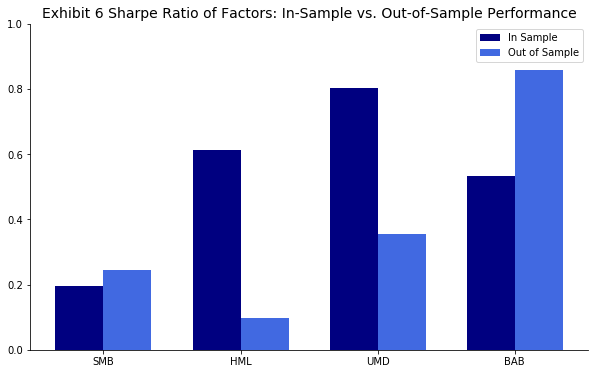

In [94]:
# Exhibit 6 updated

SMB_out=data[(data.date >= 197601) & (data.date <= 202012)]
SMB_out=SMB_out.reset_index(drop=True)
SMB_out.iloc[:,1:]=SMB_out.iloc[:,1:].astype(float)
#mean
smb_1=SMB_out['SMB'].mean()*12
#sd
smb_2=SMB_out['SMB'].std()*(12)**0.5
#SMB out of sample Sharp ratio 
smb_out=smb_1/smb_2


#HML out of sample
HML_out=data[(data.date >= 199101) & (data.date <= 202012)]
HML_out=HML_out.reset_index(drop=True)
HML_out['HML']=HML_out['HML'].astype(float)
hml_out_1=HML_out['HML'].mean()*12
hml_out_2=HML_out['HML'].std()*(12)**0.5
#HML ot of sample Sharp ratio
hml_out=hml_out_1/hml_out_2

#UMD out of sample
UMD_out=UMD[(UMD.date >= 199001) & (UMD.date <= 202012)]
UMD_out=UMD_out.rename(columns={"Mom   ": "Mom"})
UMD_out['Mom']=UMD_out['Mom'].astype(float)

umd_out_1=UMD_out['Mom'].mean()*12
umd_out_2=UMD_out['Mom'].std()*(12)**0.5
#UMD out of sample Sharp ratio
umd_out=umd_out_1/umd_out_2

#BAB
#BAB out of sample
BAB_out=bab[(bab.date >= 196901) & (bab.date <= 202012)]
BAB_out=BAB_out.reset_index(drop=True)
BAB_out['USA']=BAB_out['USA'].str.strip('%').astype(float)
bab_out_1=BAB_out['USA'].mean()*12
bab_out_2=BAB_out['USA'].std()*(12)**0.5
#BAB out of sample Sharp ratio
bab_out=bab_out_1/bab_out_2

#Chart
labels=['SMB','HML','UMD','BAB']
in_sample=[smb_in,hml_in,umd_in,bab_in]
out_of_sample=[smb_out,hml_out,umd_out,bab_out]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, in_sample, width, label='In Sample',color="#000080")
rects2 = ax.bar(x + width/2, out_of_sample, width, label='Out of Sample',color='#4169E1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Exhibit 6 Sharpe Ratio of Factors: In-Sample vs. Out-of-Sample Performance',fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.set_ylim([0, 1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()
fig.savefig("Exhibit 6 updated.png")